# Using Deep reinforcement learning to play Atari

![Q learning](fig/q-learning.png)
[source](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/deep_q_learning.html)

Influential paper: [Human-level control through deep reinforcement learning](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning/)

## Plan

* Random agent
* DQN agent
* Exploration / Experience replay 
* Double DQN
* Dueling DQN

## Setup
### OpenAI Gym
OpenAI Gym is library that allows to train agents in a wide variety of environments with near-identical interface.
#### Installation
```
git clone https://github.com/openai/gym.git
cd gym
pip install -e .[all]
```
### Keras
Keras is a high-level library on the top of deep learning backends (Tensorflow, Theano)
#### Installation
```
pip install keras
```

In [2]:
import gym

import random
import numpy as np
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers import Dense, Conv2D, Flatten, Input, Reshape, Lambda
from keras.models import Sequential
from keras import backend as K
import tensorflow as tf
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In this notebook, we consider the CartPole problem where the objective is to balance the pole by applying force to the cart.

[2018-01-30 11:38:55,222] Making new env: CartPole-v0


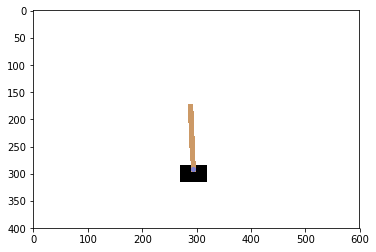

In [3]:
ENV_NAME = 'CartPole'
env = gym.make("{}-v0".format(ENV_NAME))
env.reset()
plt.imshow(env.render('rgb_array'))
env.close()

In CartPole, we observe 4 variables: position of cart, its velocity, angle of pole, and angular velocity. At any state, there are only has two possible actions: move to the left or move to the right.

In [4]:
print(env.action_space)
print(env.observation_space)

Discrete(2)
Box(4,)


## Gym API key elements
* env = gym.make(environment_name) <- sets up the environment
* env.reset() <- resets the environment to starting point
* env.step(action) <- takes action and goes to state $S_{t+1}$, returns $r_t$, $S_{t+1}$ and if game terminated.
* env.render() <- render the output

## Tensorboard logging
*Optional* - If your backend is Tensorflow you can observe some parameters during the training using the board
```
tensorboard --logdir=/tmp/logs --port=8000
```
but you need to set callbacks in the code 
```
tensorboard_cback = keras.callbacks.TensorBoard(log_dir='/tmp/logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
model.fit(...inputs and parameters..., callbacks=[tensorboard_cback])
```
more details in the documentation https://keras.io/callbacks/#tensorboard and on [Stackoverflow](https://stackoverflow.com/questions/42112260/how-do-i-use-the-tensorboard-callback-of-keras) 


## Random agent

The world's simplest agent that independently chooses random actions at each state.

In [5]:
class RandomAgent(object):
    """The world's simplest agent!"""
    def __init__(self, action_space):
        self.action_space = action_space

    def get_action(self, state):
        return self.action_space.sample()

## Play loop

Note that CartPole Gym environment is considered as solved as soon as you find a policy which scores 200 on average.

Episode 0, Total reward 16.0
Episode 1, Total reward 19.0
Episode 2, Total reward 13.0


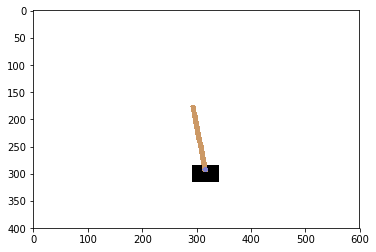

In [58]:
def display_policy(env, agent, add_batch_dim=False, render=False, episodes = 1):
    done = False
    for i in range(episodes):
        state = env.reset()
        if add_batch_dim: 
                # This is a technical reshaping because models are predict on a batch
                state = np.reshape(state, [1, state_size])
        total_reward = 0
        while True:
            plt.imshow(env.render('rgb_array'))
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            if add_batch_dim:
                next_state = np.reshape(next_state, [1, state_size])
            state = next_state
            total_reward += reward 
            if done:
                print("Episode {}, Total reward {}".format(i, total_reward))
                break       
    env.close()
    
    
display_policy(env, RandomAgent(env.action_space), episodes=3)    


## DQN Agent - Online

This is a [Keras](https://keras.io/) code for training a Deep Q-Network (DQN) without exploration. 

We start with the simple DQN agent -- the trained network is immediatly used to collect the new training data. Unless you are *very* lucky you won't be able to solve the task. 

## Task 1

* Replace the `???` by values that seem reasonnable to you ($\gamma>1$ is not reasonnable and big steps are prone to numerical instability). 
* See how the policy training fails. 

In [13]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size
        # hyper parameters 
        self.gamma = ???
        self.learning_rate = ???
        
        self.model = self.build_model()
        
    # approximate Q function using Neural Network
    # state is input and Q Value of each action is output of network
    def build_model(self):
        model = Sequential()
        # this is a simple one hidden layer model, but it should be enough for our task
        # it is much easier to train with different achitectures (stack layers, change activation)
        model.add(Dense(128, input_dim=self.state_size, activation='tanh'))
        model.add(Dense(self.action_size, activation='linear'))
        model.summary()
        # 1/ you can try different losses, for ex., logcosh loss is a twice differenciable approximation of Huber loss
        # 2/ from a theoretical perspective learning rate should decay with time to guarantee convergence 
        model.compile(loss='???', optimizer=???)
        return model

    # get action from model using greedy policy
    def get_action(self, state):
        q_value = self.model.predict(state)
        return np.argmax(q_value[0]) # the [0] is because keras outputs a set of predictions of size 1

    # train the target network on the selected action and transition
    def train_model(self, action, state, next_state, reward, done):
        target = self.model.predict(state)
        # we use our internal model in order to estimate the V value of the next state 
        target_val = self.model.predict(next_state)
        # Q Learning: target values should respect the Bellman's optimality principle
        if done: # we are on a terminal state
            target[0][action] = reward
        else:
            target[0][action] = reward + self.gamma * (np.amax(target_val))

        # and do the model fit!
        (self.model.train_on_batch(state, target))

## Core training loop

In [15]:
state_size = env.observation_space.shape[0]
agent = DQNAgent(state_size, env.action_space.n)

episode_count = 50
done = False

for i in range(episode_count):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    while True:
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        total_reward += reward
        agent.train_model(action, state, next_state, reward, done)
        
        state = next_state
        if done:
            if i % 10 == 1:
                print("Episode {}, Total reward {}".format(i, total_reward))
            break

env.close()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
Episode 1, Total reward 9.0
Episode 11, Total reward 9.0
Episode 21, Total reward 11.0
Episode 31, Total reward 10.0
Episode 41, Total reward 9.0


## DQN Agent with Exploration

This is the first agent that is going to solve the task. It will typically require to run a few hundred episodes to collect the data. 

The difference with the previous agent is that we add an exploration mechanism in order to take care of the data collection for the training. We advise to use an $\varepsilon_n$-greedy, meaning that the value of $\varepsilon$ is going to decay over time. Several kind of decays can be found in the litterature. A simple one is to use a mutiplicative update of $\varepsilon$ by a constant smaller than 1 as long as $\varepsilon$ is smaller than a small minimal rate (typically, in the range 1%-5%).

## Task 2

* Code your exploration marked by TODOs
* Tune the hyperparameters (including the ones from the previous section) in order to solve the task. This may be not so easy and will likely require more than 500 episodes and a final small value of epsilon. Next sessions will be about techniques to increase sample efficiency (i.e require less episodes).

**Trouble shooting:** *some working parameters and network architecture are provided at the bottom of this page in case you have trouble finding a working situation.*

In [16]:
class DQNAgentWithExploration(DQNAgent):
    def __init__(self, state_size, action_size):
        super(DQNAgentWithExploration, self).__init__(state_size, action_size)
        # exploration schedule parameters 
        # TODO: store your additional parameters here 

    # decay epsilon
    def update_epsilon(self):
        # TODO: write the code for your decay  

    # get action from model using greedy policy
    def get_action(self, state):
        # TODO: add the exploration 
        q_value = self.model.predict(state)
        return np.argmax(q_value[0])

In [17]:
state_size = env.observation_space.shape[0]
agent = DQNAgentWithExploration(state_size, env.action_space.n)

episode_count = 501
done = False

for i in range(episode_count):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    while True:
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        total_reward += reward
        agent.train_model(action, state, next_state, reward, done)
        agent.update_epsilon()

        state = next_state
        if done:
            if i % 20 == 0:
                print("Episode {}, Total reward {}, Epsilon {:0.2f}".format(i, total_reward, agent.epsilon))
            break

env.close()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_5 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
Episode 1, Total reward 32.0, Epsilon 0.76
Episode 21, Total reward 11.0, Epsilon 0.20
Episode 41, Total reward 10.0, Epsilon 0.07
Episode 61, Total reward 9.0, Epsilon 0.03
Episode 81, Total reward 10.0, Epsilon 0.01
Episode 101, Total reward 9.0, Epsilon 0.01
Episode 121, Total reward 8.0, Epsilon 0.01
Episode 141, Total reward 10.0, Epsilon 0.01
Episode 161, Total reward 11.0, Epsilon 0.01
Episode 181,

## DQN Agent with Exploration and Experience Replay

We are now going to save some samples in a limited memory in order to assemble mini-batches during the training. The exploration policy remains the same as in the previous section.  

Reference: [Human-level control through deep reinforcement learning](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning/)

## Task 3

* Fill the TODO section that assembles the mini-batch sent to the optimizer.

In [43]:
from collections import deque

class DQNAgentWithExplorationAndReplay(DQNAgentWithExploration):
    def __init__(self, state_size, action_size):
        super(DQNAgentWithExplorationAndReplay, self).__init__(state_size, action_size)
        self.batch_size = 32
        self.train_start = 64
        # create replay memory using deque
        self.memory = deque(maxlen=5000)

    # save sample <s,a,r,s'> to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))        

    
    def train_model(self):
        if len(self.memory) < self.train_start:
            return
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        update_input = np.zeros((batch_size, self.state_size))
        update_target = np.zeros((batch_size, self.state_size))
        action, reward, done = [], [], []
        
        # pick samples randomly from replay memory (using batch_size)
        for i in range(self.batch_size):
            update_input[i] = mini_batch[i][0]
            action.append(mini_batch[i][1])
            reward.append(mini_batch[i][2])
            update_target[i] = mini_batch[i][3]
            done.append(mini_batch[i][4])

        target = self.model.predict(update_input)
        target_val = self.model.predict(update_target)

        for i in range(self.batch_size):
            # TODO
           
        # and do the model fit!
        ("loss :", self.model.train_on_batch(update_input, target))

In [51]:
state_size = env.observation_space.shape[0]
agent = DQNAgentWithExplorationAndReplay(state_size, env.action_space.n)

episode_count = 301
done = False

for i in range(episode_count):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    while True:
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        # save the sample <s, a, r, s'> to the replay memory
        agent.append_sample(state, action, reward, next_state, done)
        total_reward += reward
        agent.train_model()
        agent.update_epsilon()

        state = next_state
        if done:
            if i % 20 == 0:
                print("Episode {},\t Total reward {},\t Memory length {},\t Epsilon {:0.2f}".format(i, total_reward, len(agent.memory), agent.epsilon))
            break

env.close()

Episode 0,	 Total reward 161.0,	 Memory length 5000,	 Epsilon 0.00
Episode 20,	 Total reward 9.0,	 Memory length 5000,	 Epsilon 0.00
Episode 40,	 Total reward 146.0,	 Memory length 5000,	 Epsilon 0.00
Episode 60,	 Total reward 200.0,	 Memory length 5000,	 Epsilon 0.00
Episode 80,	 Total reward 200.0,	 Memory length 5000,	 Epsilon 0.00
Episode 100,	 Total reward 171.0,	 Memory length 5000,	 Epsilon 0.00
Episode 120,	 Total reward 11.0,	 Memory length 5000,	 Epsilon 0.00
Episode 140,	 Total reward 133.0,	 Memory length 5000,	 Epsilon 0.00
Episode 160,	 Total reward 157.0,	 Memory length 5000,	 Epsilon 0.00
Episode 180,	 Total reward 200.0,	 Memory length 5000,	 Epsilon 0.00
Episode 200,	 Total reward 200.0,	 Memory length 5000,	 Epsilon 0.00
Episode 220,	 Total reward 9.0,	 Memory length 5000,	 Epsilon 0.00
Episode 240,	 Total reward 9.0,	 Memory length 5000,	 Epsilon 0.00
Episode 260,	 Total reward 200.0,	 Memory length 5000,	 Epsilon 0.00
Episode 280,	 Total reward 145.0,	 Memory lengt

## Double DQN Agent with Exploration and Experience Replay

Now we train two identical networks. We keep frozen for some timesteps the network that is in charge of evaluation (i.e that is used to compute targets).
Note that you can find some variants where the target network is updated at each timestep but with a small fraction of the difference with the policy network.

Reference: [Deep Reinforcement Learning with Double Q-learning](https://arxiv.org/abs/1509.06461)

## Task 4

* Implement Double DQN, this is should reduce the variance of predicted Q-values

In [20]:
class DoubleDQNAgentWithExplorationAndReplay(DQNAgentWithExplorationAndReplay):
    def __init__(self, state_size, action_size):
        super(DoubleDQNAgentWithExplorationAndReplay, self).__init__(state_size, action_size)
        # TODO: initialize a second model

    def update_target_model(self):
        # TODO: copy weights from the model used for action selection to the model used for computing targets       

    
    def train_model(self):
        if len(self.memory) < self.train_start:
            return
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        update_input = np.zeros((batch_size, self.state_size))
        update_target = np.zeros((batch_size, self.state_size))
        action, reward, done = [], [], []
        
        # pick samples randomly from replay memory 
        for i in range(self.batch_size):
            update_input[i] = mini_batch[i][0]
            action.append(mini_batch[i][1])
            reward.append(mini_batch[i][2])
            update_target[i] = mini_batch[i][3]
            done.append(mini_batch[i][4])

        target = self.model.predict(update_input)
        # TODO: compute targets (in target_val)
        
        for i in range(self.batch_size):
            # approx Q Learning
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + self.gamma * (np.amax(target_val[i]))

        # and do the model fit!
        self.model.train_on_batch(update_input, target)

In [33]:
state_size = env.observation_space.shape[0]
agent = DoubleDQNAgentWithExplorationAndReplay(state_size, env.action_space.n)

episode_count = 301
done = False

# TODO: add the update of the target model at the end of each episode
for i in range(episode_count):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    while True:
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        # save the sample <s, a, r, s'> to the replay memory
        agent.append_sample(state, action, reward, next_state, done)
        total_reward += reward
        agent.train_model()
        agent.update_epsilon()

        state = next_state
        if done:
            if i % 20 == 0:
                print("Episode {},\t Total reward {},\t Memory length {},\t Epsilon {:0.2f}".format(i, total_reward, len(agent.memory), agent.epsilon))
            break

env.close()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 24)                120       
_________________________________________________________________
dense_23 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 24)                120       
_________________________________________________________________
dense_26 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_27 (De

To see the actual performance of the policy, we should set $\varepsilon=0$

Episode 0, Total reward 200.0


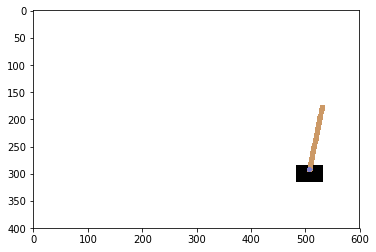

In [56]:
agent.epsilon = 0
display_policy(env, agent, episodes=1, add_batch_dim=True)

## Dueling DQN 

Dueling network contains two separate estimators: one for the state value function and one for the state-dependent action advantage function. This should reduce the variance of Q-values estimation.

Reference: [Dueling Network Architectures for Deep Reinforcement Learning](https://arxiv.org/abs/1511.06581)

## Task 5

* Implement Dueling DQN

# More ideas

* Compute averaged curves over several initialisations for each algorithm
* Shape the reward in order to keep the cart close to its initial position
* Do not sample uniformly in the memory for the batches using [prioritized replay](https://arxiv.org/pdf/1511.05952.pdf)
* (Painfull) learn a policy with a bar starting from the bottom position
* [Visualize](http://arxiv.org/abs/1412.6806) important areas of the pictures for taking the decision using saliency maps computed by guided backpropagation
* Try policy gradient method

# Spoiler
Some working parameters for the network: 
* gamma = 0.995
* learning_rate = 0.001
* Exploration by $\varepsilon$-greddy with multiplicative decay and minimal value 
  ```
  self.epsilon = 1.0
  self.epsilon_decay = 0.995
  self.epsilon_min = 0.01
  ```
* Structure of the network: 2 couches de 24 neurones complètement connectées avec activation relu, Cost MSE et optimisé par descente de gradient Adam:
  ```
  model.add(Dense(24, input_dim=self.state_size, activation='relu'))
  model.add(Dense(24, activation='relu'))
  model.add(Dense(self.action_size, activation='linear'))
  model.summary()
  model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
  ```
        